# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense

# Data Collection and Organization

In [2]:
#Loading the data
VIX = pd.read_csv('data/VIX.csv', header = 2)
DOW = pd.read_csv('data/DOW.csv', header = 2)
GFD = pd.read_csv('data/GFD_TBILL_DAILY.csv', header = 2)
GOLD = pd.read_csv('data/GOLD.csv', header = 2)
SPX = pd.read_csv('data/SPX.csv', header = 2)
# I'm not using US_10YR because it contains duplicate values for many dates
#US_10YR = pd.read_csv('data/US_10yr_yield.csv', header = 2)

# Define a helper function to process the data
def process_data(df, label):
    
    # Convert the Date column from a string to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Get only the Dates earlier than 2021-10-21 since we aren't predicting into the future
    df = df.loc[(df['Date'] <= '2021-10-21')]
    
    # Reverse the data to go backward in time
    df = df.sort_values(by='Date', ascending=False).reset_index(drop=True)
    
    # Drop the 'Ticker' and 'Open' columns
    df = df.drop(columns = ['Ticker', 'Open'], axis=1)
    
    # Rename the 'Close' column with the passed label
    df = df.rename(columns={'Close': label})
    
    return df

# Process all of the data
VIX = process_data(VIX, 'VIX')
DOW = process_data(DOW, 'DOW')
GFD = process_data(GFD, 'GFD')
GOLD = process_data(GOLD, 'GOLD')
SPX = process_data(SPX, 'SPX')
#US_10YR = process_data(US_10YR, 'US_10YR')

# Merge all of the data into one large dataframe
from functools import reduce

dfs = [VIX, DOW, GFD, GOLD, SPX]
#dfs = [VIX, DOW, GFD, GOLD, SPX, US_10YR]
data = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), dfs)

# Sort the data by descending date
data = data.sort_values(by='Date', ascending=False).reset_index(drop=True)

# For each column in the dataframe fill in the gaps where there is no data by taking the last valid value
data = data.fillna(method = 'bfill')

data

,Date,VIX,DOW,GFD,GOLD,SPX
0,2021-10-21,15.01,35603.08,11258.083417,1778.00,9506.91
1,2021-10-20,15.49,35609.34,11258.064911,1778.00,9477.82
2,2021-10-19,15.70,35457.31,11258.049489,1779.55,9443.12
3,2021-10-18,16.31,35258.61,11258.034067,1767.85,9373.68
4,2021-10-17,16.30,35294.76,11258.015560,1772.65,9342.15
...,...,...,...,...,...,...
84264,1791-02-05,NaN,NaN,1.000822,NaN,NaN
84265,1791-02-04,NaN,NaN,1.000658,NaN,NaN
84266,1791-02-03,NaN,NaN,1.000493,NaN,NaN
84267,1791-02-02,NaN,NaN,1.000329,NaN,NaN


# Data Visualization

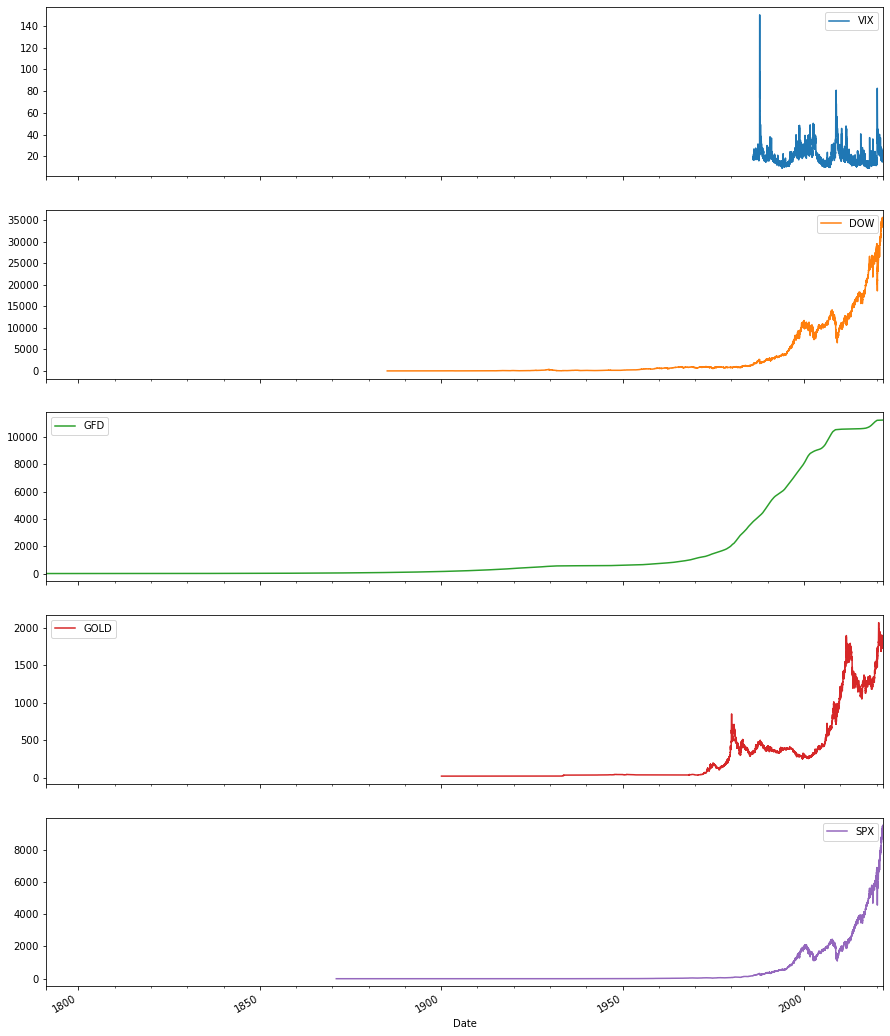

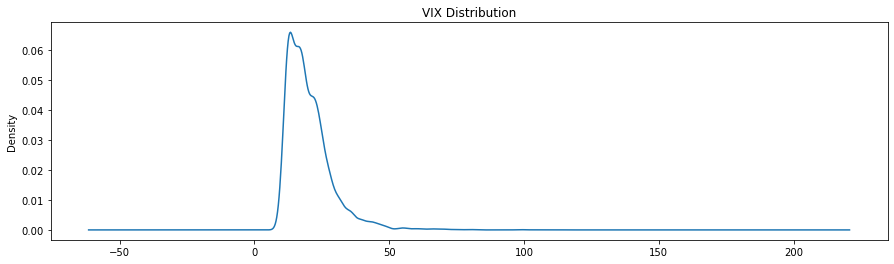

In [3]:
data.plot('Date', subplots=True, figsize = (15,20))
plt.show()

data['VIX'].plot(kind = 'kde', figsize = (15,4), title = 'VIX Distribution')
plt.show()

# Data Processing

In [4]:
def lstm_data_processing(data, start_date, end_date, n_time_steps = 90, include_vix = True):

    # Get the indices of the start date and the end date
    start_index = int(np.where(data[:,0] == pd.to_datetime(start_date))[0])
    end_index = int(np.where(data[:,0] == pd.to_datetime(end_date))[0])
    
    # Flag to set if VIX data is included in the training set
    if include_vix:
        # Get all of the input data (X)
        X_data = data[:,1:].astype('float32')
    else:
        # Get all of the input data (X)
        X_data = data[:,2:].astype('float32')   
    
    # Create an empty array to store the restructured input data
    X_data_extended = np.zeros((X_data.shape[0], n_time_steps, X_data.shape[-1]))

    # Loop through all samples 
    for i in range(start_index, end_index+1):
        X_data_extended[i] = X_data[i-n_time_steps:i,:]
    
    # Get all of the input data (X) for the desired date range
    X_data = X_data_extended[start_index:end_index+1]

    # Get all of the output data (Y) for the desired date range
    y_data = data[start_index:end_index+1,1].astype('float32')
    
    return X_data, y_data

# Define a function to process the data for Bidirectional LSTM
def bidirectional_data_processing(data, start_date, end_date, n_time_steps = 30):

    # Get the indices of the start date and the end date
    start_index = int(np.where(data[:,0] == pd.to_datetime(start_date))[0])
    end_index = int(np.where(data[:,0] == pd.to_datetime(end_date))[0])
    
    # Get all of the input data (X)
    X_data = data[:,2:].astype('float32')
    
    # Create an empty array to store the restructured input data
    X_data_extended = np.zeros((X_data.shape[0], 2*n_time_steps+1, X_data.shape[-1]))

    # Loop through all samples 
    for i in range(start_index, end_index+1):
        X_data_extended[i] = X_data[i-n_time_steps:i+n_time_steps+1,:]
    
    # Get all of the input data (X) for the desired date range
    X_data = X_data_extended[start_index:end_index+1]

    # Get all of the output data (Y) for the desired date range
    y_data = data[start_index:end_index+1,1].astype('float32')
    
    return X_data, y_data

# Convert the data from a pandas dataframe to a numpy array
np_data = data.to_numpy()

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = np_data.copy()
scaled_data[:,1:] = scaler.fit_transform(scaled_data[:,1:])

# Define the number of timesteps to look forward and backward (total number of timesteps is 2*n_timesteps+1)
n_time_steps = 90

# Split data into train, dev, and test sets
X_train, y_train = lstm_data_processing(scaled_data, start_date = '12/31/2020', end_date = '01/01/1991', n_time_steps = n_time_steps, include_vix = False)
X_dev, y_dev = lstm_data_processing(scaled_data, start_date = '12/31/1990', end_date = '07/01/1988', n_time_steps = n_time_steps, include_vix = False)
X_test, y_test = lstm_data_processing(scaled_data, start_date = '06/30/1988', end_date = '01/01/1986', n_time_steps = n_time_steps, include_vix = False)

# Verify the shapes of the input and output data
print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)
print(X_test.shape)
print(y_test.shape)

(10958, 90, 4)
(10958,)
(914, 90, 4)
(914,)
(912, 90, 4)
(912,)


# LSTM Model
## Model Definition

In [5]:
# Building the model
lstm_model = Sequential()

# Adding a Bidirectional LSTM layer
lstm_model.add(LSTM(64, return_sequences=False, dropout=0.5, input_shape=(X_train.shape[1], X_train.shape[-1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mse', optimizer='adam')

## Model Training

In [6]:
# Training the model
lstm = lstm_model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_dev, y_dev))

Epoch 1/50
86/86 [==============================] - 7s 65ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 2/50
86/86 [==============================] - 6s 70ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 3/50
86/86 [==============================] - 6s 67ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 4/50
86/86 [==============================] - 5s 63ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 5/50
86/86 [==============================] - 5s 58ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 6/50
86/86 [==============================] - 6s 66ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 7/50
86/86 [==============================] - 5s 58ms/step - loss: 0.0024 - val_loss: 0.0049
Epoch 8/50
86/86 [==============================] - 5s 62ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 9/50
86/86 [==============================] - 6s 64ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 10/50
86/86 [==============================] - 6s 67ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 11/

In [8]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17664     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


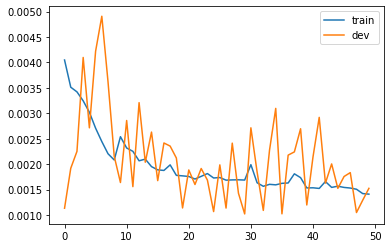

In [9]:
# plot training and dev losses over epoch
plt.plot(lstm.history['loss'], label='train')
plt.plot(lstm.history['val_loss'], label='dev')
plt.legend()
plt.show()

## Model Prediction and Visualization

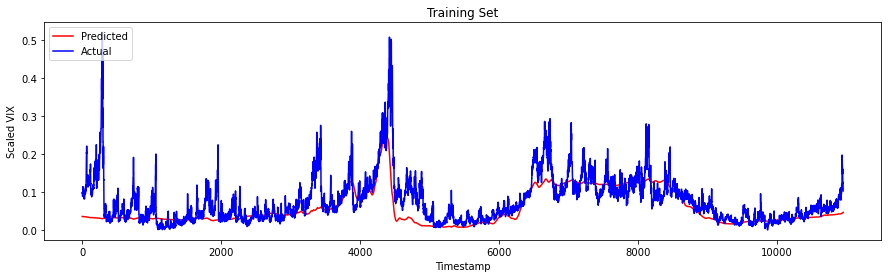

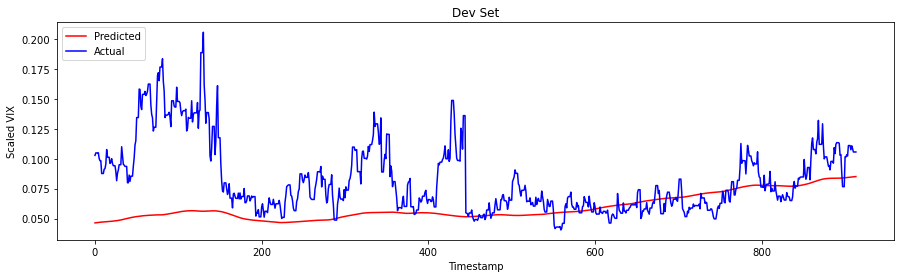

In [11]:
# make predictions for the training and dev sets
y_train_hat = lstm_model.predict(X_train)
y_dev_hat = lstm_model.predict(X_dev)

# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(y_train_hat, color='red', label='Predicted')
axs.plot(y_train, color='blue', label='Actual')
plt.title('Training Set')
plt.xlabel('Timestamp')
plt.ylabel('Scaled VIX')
plt.legend(loc='upper left')
plt.show()

fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(y_dev_hat, color='red', label='Predicted')
axs.plot(y_dev, color='blue', label='Actual')
plt.title('Dev Set')
plt.xlabel('Timestamp')
plt.ylabel('Scaled VIX')
plt.legend(loc='upper left')
plt.show()